In [24]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, MultiLineString
import networkx as nx
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Read the file and convert to WGS84 coordinate system
gdf = gpd.read_file("../local_data/street_data_raw.gpkg", layer='geoz_2023.av_geb_strassenstueck')
gdf = gdf.to_crs("EPSG:4326")  # WGS84

# Initialize an empty graph
G = nx.Graph()

# Extract LineString geometries from gdf
lines = gdf[gdf.geometry.type == 'LineString']

# Add edges to the graph based on LineString coordinates
for line in lines.geometry:
    coords = list(line.coords)
    for i in range(len(coords) - 1):
        G.add_edge(coords[i], coords[i+1])
        

# Create a MultiLineString from all edges in the graph
edges = [LineString([u, v]) for u, v in G.edges()]
merged_lines = MultiLineString(edges)
big_network = unary_union(merged_lines)

# Create a GeoDataFrame for the merged network
network_gdf = gpd.GeoDataFrame({"geometry": [big_network]}, crs=lines.crs)


In [15]:

# Create a convex hull polygon that encloses all the lines
convex_hull_polygon = lines.geometry.union_all().convex_hull

# Add the convex hull polygon to the GeoDataFrame
convex_hull_gdf = gpd.GeoDataFrame({"geometry": [convex_hull_polygon]}, crs=network_gdf.crs)


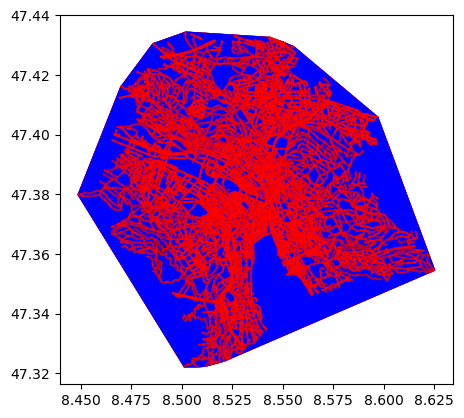

In [ ]:
fig, ax = plt.subplots()
network_gdf.plot(ax=ax, color='red')
convex_hull_gdf.plot(ax=ax, color='blue')
plt.show()


In [ ]:

# Save the network to a file, ensuring only one file gets created
network_gdf.to_file("../local_data/street_data_cleaned.geojson", driver="GeoJSON")
'''
The code above reads a shapefile, extracts the LineString geometries, and creates a graph from the edges of the LineStrings.
It then merges the edges into a single MultiLineString and saves it to a new shapefile.
'''

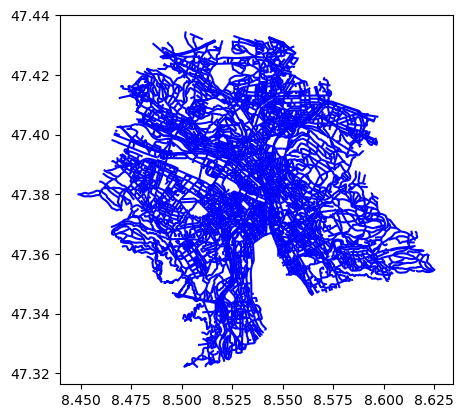

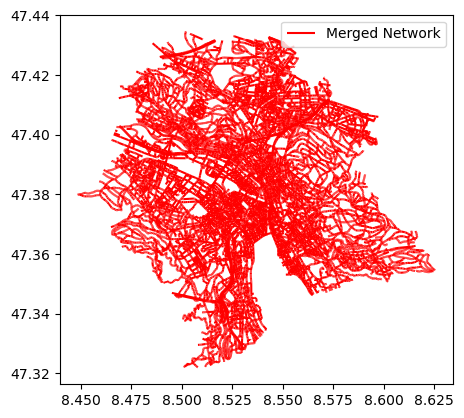

In [23]:
# Plot the original and merged network
lines.plot(color="blue", label="Original")
network_gdf.plot(color="red", label="Merged Network")
plt.legend()
plt.show()

In [30]:
listings = pd.read_csv("../local_data/listings.csv")
# Define the required columns
required_cols_L = ["name", "latitude", "longitude", "price"]
# Drop unnecessary columns and handle missing values
listings = listings.dropna(subset=required_cols_L).copy()


tourism = pd.read_csv("../local_data/tourism.csv")
# Define the required columns
required_cols_T = ["identifier", "latitude", "longitude"]
# Drop missing values
tourism = tourism.dropna(subset=required_cols_T).copy()
# rename identifier to id
tourism = tourism.rename(columns={"identifier": "id"})

In [31]:

def process_listings(df: pd.DataFrame) -> gpd.GeoDataFrame:

    # Select relevant columns and create a GeoDataFrame
    df = df[["id","price", "latitude", "longitude"]].copy()
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Drop the original latitude and longitude columns
    geo_df.drop(columns=["latitude", "longitude"], inplace=True)
    
    return geo_df

def process_tourism(df: pd.DataFrame) -> gpd.GeoDataFrame:

    # Select relevant columns and create a GeoDataFrame
    df = df[["id", "latitude", "longitude"]].copy()
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Drop the original latitude and longitude columns
    geo_df.drop(columns=["latitude", "longitude"], inplace=True)
    
    return geo_df

# Process data
geolistings = process_listings(listings)

# Process data2
geotourism = process_tourism(tourism)

In [18]:
# Create a 500-meter buffer around the convex hull polygon
buffered_polygon = convex_hull_polygon.buffer(0.005)  # 0.005 degrees ~ 500 meters

# Filter geotourism points that are within the buffered polygon
geotourism_within_buffer = geotourism[geotourism.geometry.within(buffered_polygon)]

In [19]:

geotourism_within_buffer

,id,geometry
0,88375,POINT (8.53364 47.36983)
1,88366,POINT (8.52172 47.38952)
3,326061,POINT (8.52603 47.37711)
4,168166,POINT (8.54355 47.37139)
5,86653,POINT (8.54408 47.37549)
...,...,...
960,1614,POINT (8.51441 47.39961)
964,231310,POINT (8.51173 47.39051)
965,1740,POINT (8.51813 47.3886)
972,2987,POINT (8.53566 47.3623)


In [57]:
import osmnx as ox

# Download a street network for Zurich
G2 = ox.graph_from_place("Zurich, Switzerland", network_type="walk")

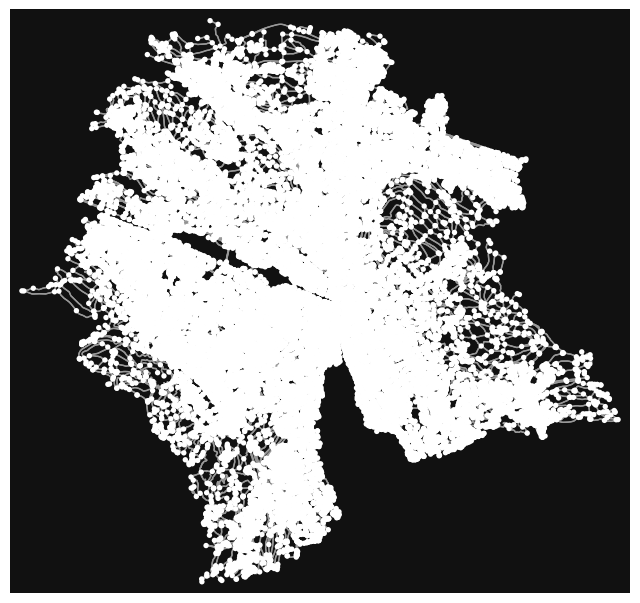

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph(G2)

In [ ]:
import numpy as np
from shapely.geometry import Point
import networkx as nx

def calculate_tourism_score(geolistings: gpd.GeoDataFrame, 
                          geotourism: gpd.GeoDataFrame,
                          network_gdf: gpd.GeoDataFrame,
                          max_distance: float = 0.005) -> gpd.GeoDataFrame:
    """
    Calculate tourism score for each Airbnb listing based on proximity to attractions.
    
    Args:
        geolistings: GeoDataFrame with Airbnb locations
        geotourism: GeoDataFrame with tourist attractions
        network_gdf: Street network
        max_distance: Maximum distance to consider (in degrees, ~500m)
    """
    # Create copy to avoid modifying original
    listings_scored = geolistings.copy()
    
    # Initialize scores
    scores = []
    
    # Calculate score for each listing
    for idx, listing in listings_scored.iterrows():
        # Get nearby attractions within max_distance
        nearby_attractions = geotourism[geotourism.geometry.distance(listing.geometry) <= max_distance]
        
        # Calculate base score based on number and proximity of attractions
        if len(nearby_attractions) == 0:
            score = 0
        else:
            # Calculate distances to nearby attractions
            distances = [listing.geometry.distance(attr.geometry) 
                        for _, attr in nearby_attractions.iterrows()]
            
            # Score formula: sum of inverse distances, weighted by proximity
            weights = 1 / (1 + np.array(distances) / max_distance)
            score = np.sum(weights)
    
        scores.append(score)
    
    # Normalize scores to 0-100 range
    scores = np.array(scores)
    if len(scores) > 0 and scores.max() > scores.min():
        scores = 100 * (scores - scores.min()) / (scores.max() - scores.min())
    
    # Add scores to GeoDataFrame
    listings_scored['tourism_score'] = scores
    
    return listings_scored

# Calculate scores
geolistings_scored = calculate_tourism_score(geolistings, geotourism_within_buffer, network_gdf, max_distance=0.0064)

# Display top 10 listings by score
print(geolistings_scored.sort_values('tourism_score', ascending=False).head(10))

                      id    price                  geometry  tourism_score
303             13980787  $948.00   POINT (8.54192 47.3728)     100.000000
582             26142789   $91.00  POINT (8.54094 47.37227)      98.542368
168              6806405  $168.00  POINT (8.54103 47.37216)      97.862853
283             13163060   $54.00  POINT (8.54147 47.37348)      96.708366
1330            53164879   $70.00  POINT (8.54284 47.37293)      96.536809
385             16263857  $114.00  POINT (8.54261 47.37334)      96.340072
1312            52849703   $70.00  POINT (8.54235 47.37359)      96.207549
531             23035346  $139.00  POINT (8.54224 47.37186)      95.716970
2139  891135668786296902  $145.00  POINT (8.54162 47.37136)      95.315897
1634  682792272736791162  $120.00  POINT (8.54336 47.37269)      95.265575


In [37]:
# Convert the price column to numeric, removing the dollar sign and commas
geolistings_scored['price'] = geolistings_scored['price'].replace('[\$,]', '', regex=True).astype(float)

# Calculate the correlation between tourism_score and price
correlation = geolistings_scored['tourism_score'].corr(geolistings_scored['price'])

print(f"Correlation between tourism score and price: {correlation}")

Correlation between tourism score and price: 0.16393427504529348


In [58]:
import osmnx as ox
import networkx as nx
import numpy as np
from tqdm import tqdm

# Ensure G2 is defined
G2 = ox.graph_from_place("Zurich, Switzerland", network_type="walk")

def calculate_walking_scores(
    geolistings: gpd.GeoDataFrame,
    geotourism: gpd.GeoDataFrame,
    G: nx.Graph,
    max_walking_dist: float = 2000  # meters
) -> gpd.GeoDataFrame:
    """
    Calculate walking-based tourism scores for Airbnb listings.
    """
    # Convert graph to projected CRS for accurate distances
    G_proj = ox.project_graph(G)
    
    # Get nearest nodes for listings and attractions
    listings_nodes = ox.nearest_nodes(
        G_proj,
        geolistings.geometry.x,
        geolistings.geometry.y
    )
    tourism_nodes = ox.nearest_nodes(
        G_proj,
        geotourism.geometry.x,
        geotourism.geometry.y
    )
    
    # Calculate scores
    scores = []
    for listing_node in tqdm(listings_nodes, desc="Calculating scores"):
        # Get shortest paths to all attractions
        try:
            distances = [
                nx.shortest_path_length(
                    G_proj,
                    listing_node,
                    dest_node,
                    weight='length'
                )
                for dest_node in tourism_nodes
            ]
            
            # Score based on proximity and number of attractions
            valid_distances = [d for d in distances if d <= max_walking_dist]
            if not valid_distances:
                score = 0
            else:
                # Score formula: sum of inverse distances
                weights = 1 / (1 + np.array(valid_distances) / 500)  # 500m scaling
                score = np.sum(weights)
        except nx.NetworkXNoPath:
            score = 0
            
        scores.append(score)
    
    # Normalize scores
    scores = np.array(scores)
    if scores.max() > scores.min():
        scores = 100 * (scores - scores.min()) / (scores.max() - scores.min())
    
    # Add scores to GeoDataFrame
    result = geolistings.copy()
    result['walking_score'] = scores
    
    return result

# Calculate scores using OSMnx graph
geolistings_scored = calculate_walking_scores(geolistings, geotourism_within_buffer, G2)

# Show top locations
print(geolistings_scored.sort_values('walking_score', ascending=False).head())

Calculating scores: 100%|██████████| 2534/2534 [00:01<00:00, 2147.23it/s]


                      id    price                  geometry  walking_score
0                  73282  $100.00  POINT (8.51948 47.37167)          621.0
1692  716801931066684447   $99.00  POINT (8.54563 47.37516)          621.0
1685  715604932071806008   $83.00   POINT (8.4894 47.38755)          621.0
1686  716380258943464821   $99.00   POINT (8.54485 47.3768)          621.0
1687  716444823779312887   $60.00  POINT (8.49543 47.42205)          621.0


In [50]:
geolistings_scored['price'] = geolistings_scored['price'].replace('[\$,]', '', regex=True).astype(float)

geolistings_scored["price"].corr(geolistings_scored["walking_score"])

/Users/geromeracordon/miniconda3/envs/dsf/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/geromeracordon/miniconda3/envs/dsf/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


np.float64(nan)

In [52]:
geolistings_scored["walking_score"].unique()

array([621.])

In [ ]:
# Get the nodes and edges from the graph
nodes, edges = ox.graph_to_gdfs(G2, nodes=True, edges=True)

# Ensure the nodes GeoDataFrame has a CRS defined
if nodes.crs is None:
    nodes.set_crs(epsg=4326, inplace=True)

# Function to find the nearest node for a set of points
def get_nearest_nodes(gdf, graph_nodes):
    nearest_nodes = ox.nearest_nodes(
        G2,
        X=gdf.geometry.x.values,
        Y=gdf.geometry.y.values,
        return_dist=False
    )
    return nearest_nodes

# Find nearest nodes for listings and attractions
listing_nodes = get_nearest_nodes(geolistings, nodes)
attraction_nodes = get_nearest_nodes(geotourism_within_buffer, nodes)

from tqdm import tqdm
import numpy as np

# Add attraction IDs for reference
geotourism_within_buffer = geotourism_within_buffer.reset_index(drop=True)
geotourism_within_buffer['attraction_id'] = geotourism_within_buffer.index

# Create a list of attraction nodes with their IDs
attraction_node_list = list(zip(geotourism_within_buffer['attraction_id'], attraction_nodes))

# Initialize a list to hold scores
scores = []

# Loop over each listing to calculate the score
for listing_idx, listing_node in tqdm(enumerate(listing_nodes), total=len(listing_nodes), desc='Calculating scores'):
    distance_sum = 0
    attraction_count = 0

    # Loop over all attractions to compute distances
    for attraction_id, attraction_node in attraction_node_list:
        try:
            # Compute the shortest path length
            length = nx.shortest_path_length(G2, source=listing_node, target=attraction_node, weight='length')
            # You can assign weights if available; here we assume equal weight
            # For example, you can set attraction weight based on popularity
            attraction_weight = 1
            # Accumulate the score inversely proportional to distance
            distance_sum += attraction_weight / (1 + length)  # Adding 1 to avoid division by zero
            attraction_count += 1
        except nx.NetworkXNoPath:
            # If no path exists, skip this attraction
            continue

    # Calculate the average score for the listing
    if attraction_count > 0:
        score = distance_sum
    else:
        score = 0
    scores.append(score)

# Convert scores to a NumPy array
scores_array = np.array(scores)

# Normalize the scores
if scores_array.max() > 0:
    normalized_scores = 100 * (scores_array - scores_array.min()) / (scores_array.max() - scores_array.min())
else:
    normalized_scores = scores_array

# Add the normalized scores to the geolistings GeoDataFrame
geolistings['tourism_score'] = normalized_scores

# Sort listings by tourism score in descending order
top_listings = geolistings.sort_values(by='tourism_score', ascending=False)

# Display the top 10 listings
print(top_listings[['id', 'tourism_score']].head(10))
